In [1]:
# Example-6-GP-Heston
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, PyHeston
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Stéphane Crépey and  Matthew Dixon, Gaussian Process Regression for Derivative Portfolio Modeling and Application to CVA Computations, to appear in J. Computational Finance, 2020.
# c.f. https://arxiv.org/abs/1901.11081

# Overview
The purpose of this notebook is to demonstrate the fitting of a Gaussian Process Regression model (GP) to option price data. In this notebook, European option prices are generated from the Heston stochastic volatility model.  The notebook begins by building a GP Heston model using the underyling and volatility as a two-dimensional input over a maturity time grid. The strike and other model parameters are assumed fixed.

In [2]:
import PyHeston # The PyHeston package must be installed.

from BlackScholes import bsformula
import numpy as np

from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Heston pricing model

In [3]:
nInt = 1024
r0 = 0.0002
S= 100
K = 100
r = r0
sigma = 0.1
lmbda = 0.1
meanV = 0.1
v0 = 0.1
rho = -0.9
T = 2.0

In [4]:
training_number = 30 # change training size 
testing_number = 40 # use all data as test, otherwise shape not match

x1_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)
x2_train = np.array(np.linspace(0.01,1.0, training_number), dtype='float32').reshape(training_number, 1)

X1_train, X2_train = np.meshgrid(x1_train, x2_train)
x_train = np.zeros(len(X1_train.flatten())*2).reshape(len(X2_train.flatten()), 2)
x_train[:, 0] = X1_train.flatten()
x_train[:, 1] = X2_train.flatten()

In [5]:
x1_test = np.array(np.linspace(0.1, 0.9, testing_number), dtype='float32').reshape(testing_number, 1)
x2_test = np.array(np.linspace(0.05, 1.0, testing_number), dtype='float32').reshape(testing_number, 1)

X1_test, X2_test = np.meshgrid(x1_test, x2_test)

x_test = np.zeros(len(X1_test.flatten())*2).reshape(len(X2_test.flatten()), 2)
x_test[:,0] = X1_test.flatten()
x_test[:,1] = X2_test.flatten()

In [6]:
nt = 11
timegrid = np.array(np.linspace(0.0, T, nt), dtype='float32').reshape(nt, 1)

Trains GPs to a static representation of the option price surface at time snapshots of maturities

In [7]:
def trainGPs(x_train, f, timegrid):
    gps = []
    
    for time in timegrid:
        print(time)
        
        y_train = []
        for idx in range(len(x_train)):
            y_train.append(f(x_train[idx, 0], x_train[idx, 1], time))
        y_train = np.array(y_train)    
        
        sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 100.0))
        gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
        gp.fit(x_train,y_train)
        gps.append(gp)
    return gps   

Given the trained GPS and a pricing function `f`, this function predicts the option prices for some test points `x_test` over a time-grid of different maturities

In [8]:
def predictGPs(x_test, f, gps, timegrid):
    
    # Create empty lists to hold the results for each time value
    preds = []
    stds = []
    y_tests = []
    i = 0
    for time in timegrid:
        
        y_test_ = []
        for idx in range(len(x_test)):
            y_test_.append(f(x_test[idx, 0], x_test[idx, 1], time))
            
        y_test = np.array(y_test_)
        y_tests.append(y_test)
        
        pred, std = gps[i].predict(x_test, return_std=True)
        preds.append(pred)
        stds.append(std)
        i += 1
    return y_tests, preds, stds 

In [9]:
lb = 1
ub = 400
portfolio = {}
portfolio['call'] = {}
portfolio['put'] = {}

portfolio['call']['price'] = lambda x, y, z: PyHeston.HestonCall(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)
portfolio['put']['price'] = lambda x, y, z: PyHeston.HestonPut(lb+(ub-lb)*x, y, K, z, r, lmbda, meanV, sigma, rho, 0.4)

In [10]:
for key in ['call', 'put']():
    portfolio[key]['GPs'] = trainGPs(x_train, portfolio[key]['price'], timegrid)
    portfolio[key]['y_tests'], portfolio[key]['preds'], portfolio[key]['sigmas'] = predictGPs(x_test, portfolio[key]['price'], portfolio[key]['GPs'], timegrid)

[0.]
[0.2]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.4]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.6]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.8]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.2]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.4]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.6]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.8]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[2.]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller

[0.]
[0.2]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.4]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.6]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[0.8]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.2]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.4]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.6]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.8]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[2.]


/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/dez/opt/anaconda3/envs/malifice/lib/python3.6/site-packages/sklearn/gaussian_process/_gpr.py:362: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


## Plot the GP versus the testing data for each point on the timegrid

No handles with labels found to put in legend.


Time to maturity:[2.]


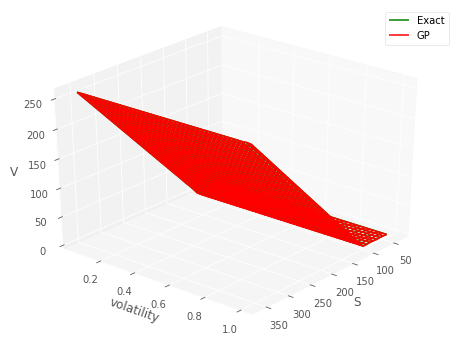

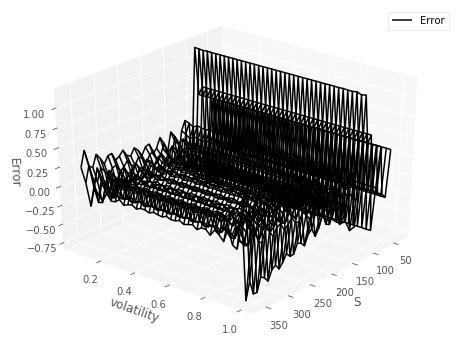

No handles with labels found to put in legend.


Time to maturity:[1.8]


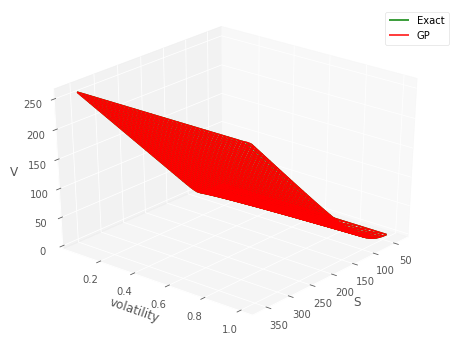

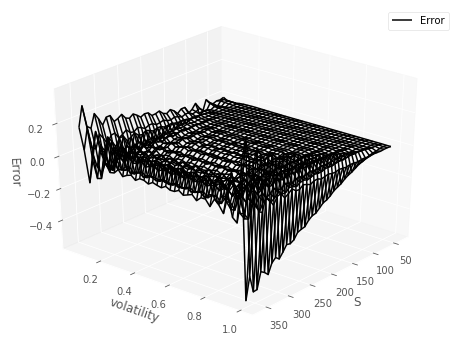

No handles with labels found to put in legend.


Time to maturity:[1.6]


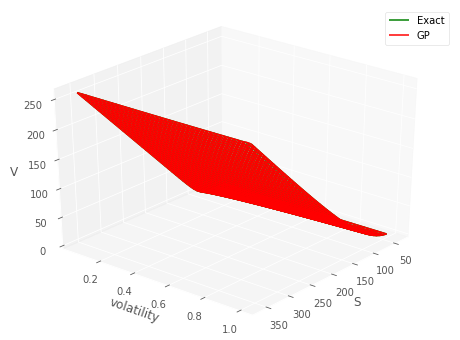

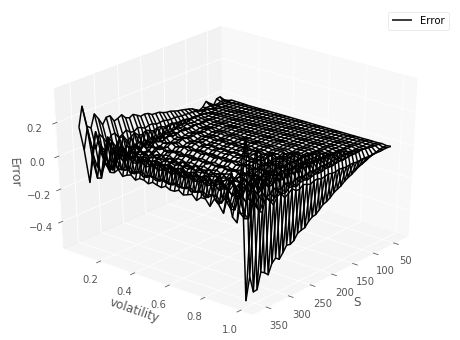

No handles with labels found to put in legend.


Time to maturity:[1.4]


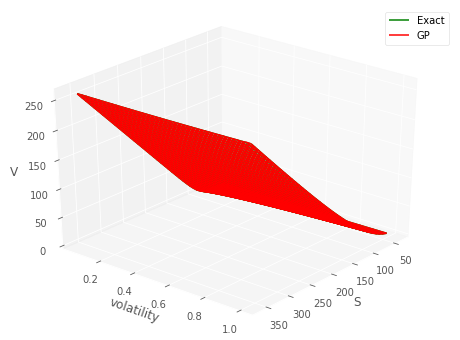

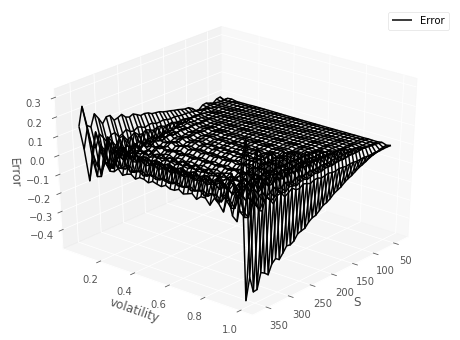

No handles with labels found to put in legend.


Time to maturity:[1.2]


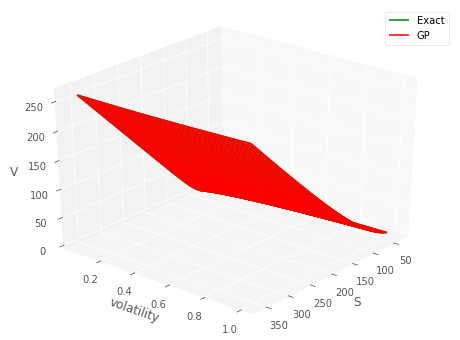

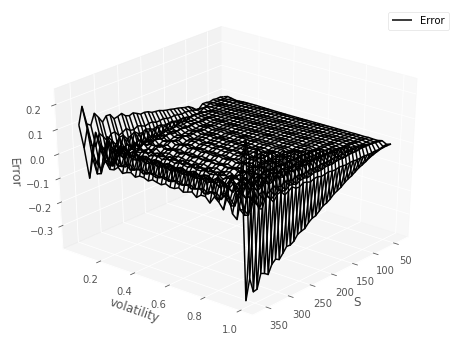

No handles with labels found to put in legend.


Time to maturity:[1.]


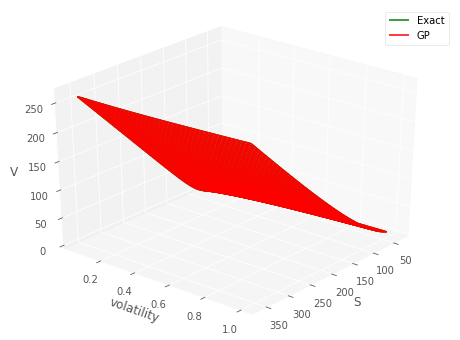

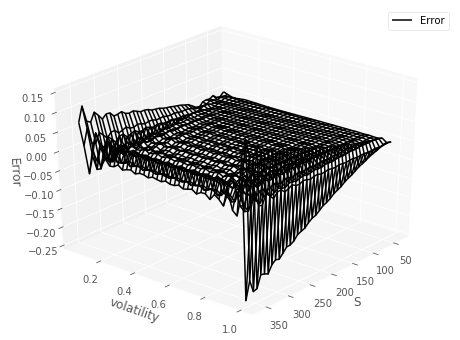

No handles with labels found to put in legend.


Time to maturity:[0.79999995]


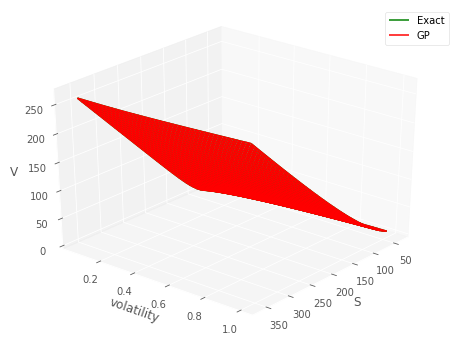

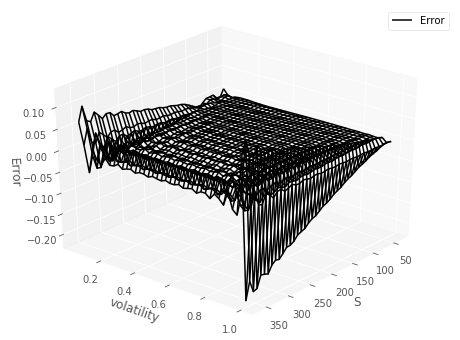

No handles with labels found to put in legend.


Time to maturity:[0.6]


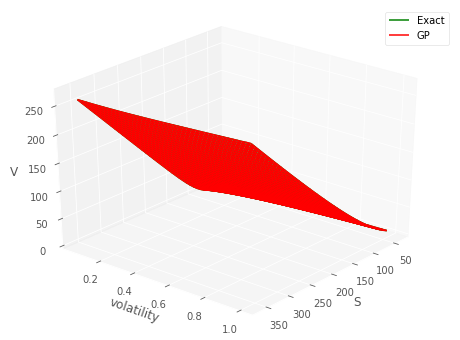

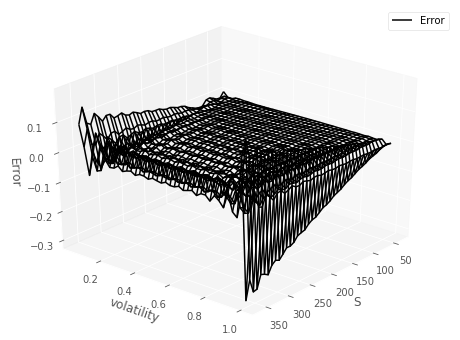

No handles with labels found to put in legend.


Time to maturity:[0.39999998]


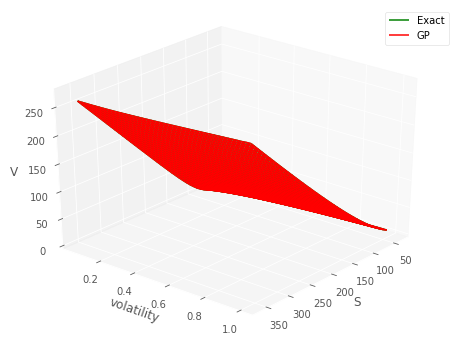

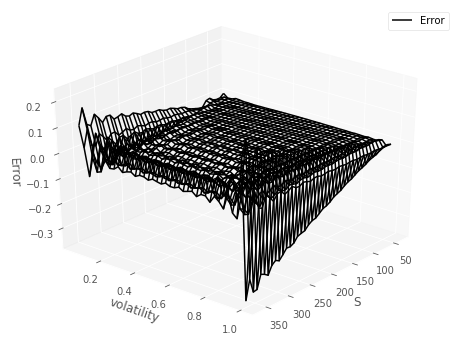

No handles with labels found to put in legend.


Time to maturity:[0.20000005]


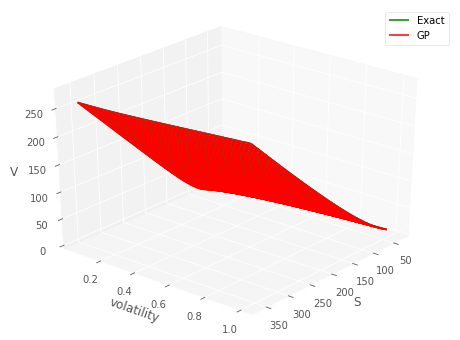

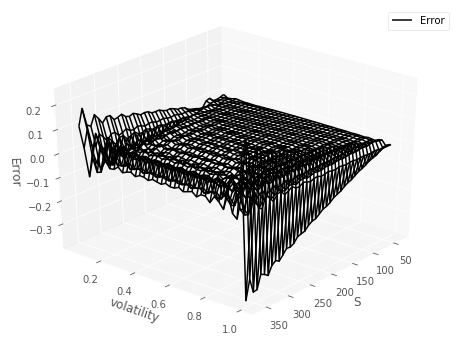

No handles with labels found to put in legend.


Time to maturity:[0.]


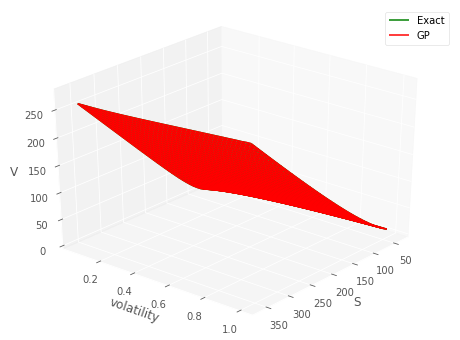

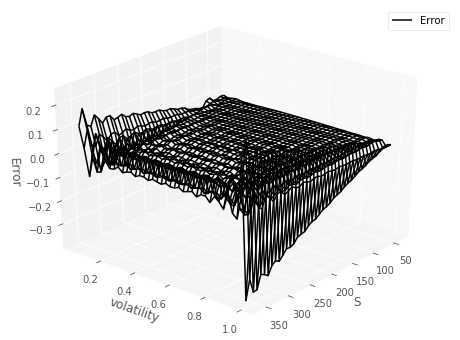

In [13]:
res = testing_number

x1_plot = lb + (ub - lb) * x_test[:, 0].reshape(res, res)
x2_plot = x_test[:, 1].reshape(res, res)

for t in range(len(timegrid)):
    print("Time to maturity:" + str(2.0 - timegrid[t]))
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = plt.axes(projection='3d')

    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})

    pred_plot = portfolio['call']['preds'][t].reshape(res, res) 
    test_plot = portfolio['call']['y_tests'][t].reshape(res, res) 
    
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot, color='green', label = 'Exact')
    ax.plot_wireframe(x1_plot, x2_plot, pred_plot, color='red', label='GP' )
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('V')
    ax.legend(loc = 'best', prop={'size':10})
    plt.show()
    
    plt.figure(figsize = (8, 6), facecolor='white', edgecolor='black')
    plt.rcParams['axes.facecolor'] = 'white'
    ax = plt.axes(projection='3d')

    # show the error plot
    angle = 40
    ax.view_init(30, angle)
    ax.plot_wireframe(x1_plot, x2_plot, test_plot-pred_plot, color='black', label = 'Error')
    ax.set_xlabel('S')
    ax.set_ylabel('volatility')
    ax.set_zlabel('Error')
    ax.legend(loc = 'best', prop={'size':10})
    plt.show()